In [1]:
import numpy as np
from sklearn.datasets import make_spd_matrix
from sklearn.linear_model import LinearRegression
import math

from opossum import UserInterface
import matplotlib.pyplot as plt
import causalml
from causalml.inference.meta import LRSRegressor
from xgboost import XGBRegressor
from causalml.inference.meta import BaseRRegressor
from causalml.propensity import ElasticNetPropensityModel

from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from matplotlib import pyplot as plt

The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.


In [20]:
## create datasets in an array?
# dataSetArray...
N = 1000
k = 10
u = UserInterface(N, k, seed=5, categorical_covariates = None)

X = [] 
assignment = [] 
y = []
treatment = []
propensityScores = []

##############################################################################################
## setupA => difficult nuisance com-ponents and an easy treatment effect function
##############################################################################################

u.generate_treatment(random_assignment = False, 
                     assignment_prob = 'low', 
                     constant_pos = False, 
                     constant_neg = False,
                     heterogeneous_pos = True, 
                     heterogeneous_neg = False, 
                     no_treatment = False, 
                     discrete_heterogeneous = False,
                     treatment_option_weights = None, 
                     intensity = 10)

y_a, X_a, assignment_A, treatment_A = u.output_data(binary=False, 
                                               x_y_relation = 'nonlinear_interaction')

X.append(X_a)
assignment.append(assignment_A)
y.append(y_a)
treatment.append(treatment_A)

##############################################################################################
## setupB => randomized trial
##############################################################################################

u.generate_treatment(random_assignment = True, 
                     assignment_prob = 0.5, 
                     treatment_option_weights = [0.0, 0.0, 0.4, 0.6, 0.0, 0.0],
                     intensity = 5)

y_b, X_b, assignment_B, treatment_B = u.output_data(binary=False, x_y_relation = 'linear_simple')

X.append(X_b)
assignment.append(assignment_B)
y.append(y_b)
treatment.append(treatment_B)

##############################################################################################
## setupC => easy propensity score and difficult baseline
##############################################################################################
u.generate_treatment(random_assignment = False, 
                     assignment_prob = 'low', 
                     constant_pos = True, 
                     constant_neg = False,
                     heterogeneous_pos = False, 
                     heterogeneous_neg = False, 
                     no_treatment = False, 
                     discrete_heterogeneous = False,
                     treatment_option_weights = None, 
                     intensity = 10)

y_C, X_C, assignment_C, treatment_C = u.output_data(binary=False, 
                                               x_y_relation = 'nonlinear_interaction')

X.append(X_C)
assignment.append(assignment_C)
y.append(y_C)
treatment.append(treatment_C)

##############################################################################################
## setupD => unrelated treatment and control arms???
##############################################################################################


In [37]:
## Get propensity scores using CausalML package. (scores for each dataset and save them in an array)
propensityScores = []

for x in range(3):
    pm = ElasticNetPropensityModel(n_fold=5, random_state=42)
    estimatedpropensityscores = pm.fit_predict(X[x], assignment[x])
    propensityScores.append(estimatedpropensityscores)

3


In [34]:
##############################################################################################
## what are we estimating here.. for one dataset.
##############################################################################################

# R Learner with propensity score input
# Calling the Base Learner class and feeding in XGB
learner_r = BaseRRegressor(learner=XGBRegressor())
ate_r_XGBRegressor = learner_r.estimate_ate(X=X[i], treatment = assignment[i], p=propensityScores[i], y=y[i])
print('Using the BaseRRegressor class and using XGB:')
print(ate_r_XGBRegressor)

# Calling the Base Learner class and feeding in LinearRegression
## comes from from sklearn.linear_model import LinearRegression.. so i assume all can come from there???
learner_rLinearRegression = BaseRRegressor(learner=LinearRegression())
ate_r_LinearRegression = learner_rLinearRegression.estimate_ate(X=X[i], treatment = assignment[i], p=propensityScores[i], y=y[i])
print('Using the BaseRRegressor class and using Linear Regression:')
print(ate_r_LinearRegression)


from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV

learner_p = BaseRRegressor(learner=DecisionTreeRegressor())
ate_r = learner_p.estimate_ate(X=X[i], treatment = assignment[i], p=propensityScores[i], y=y[i])
print('Using the BaseRRegressor class and using DecisionTree:')
print(ate_r_A)

Using the BaseRRegressor class and using XGB:
(array([-0.16087897]), array([-0.16731114]), array([-0.1544468]))
Using the BaseRRegressor class and using Linear Regression:
(array([-0.21427208]), array([-0.21843199]), array([-0.21011217]))


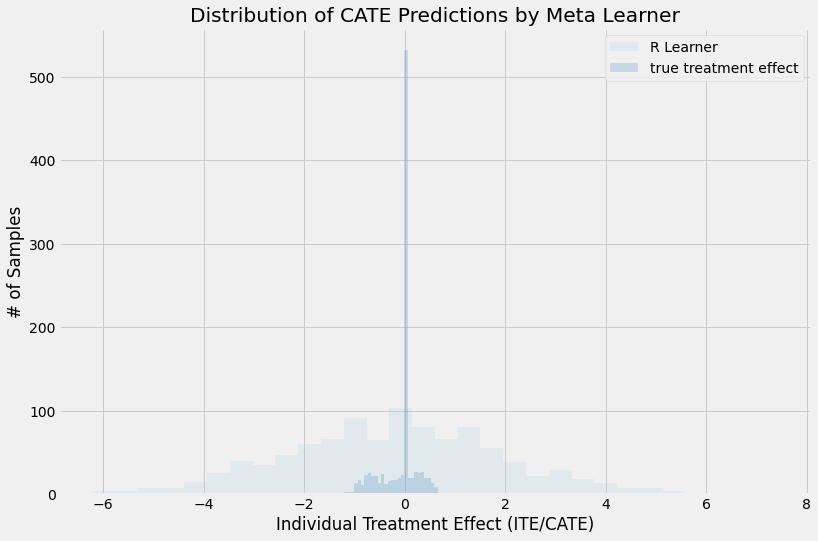

In [39]:
#to get CATE from the causalml package, predict on some holdout set? 
### FOR THIS YOU NEED TO CREATE A HOLDOUT SET AT ALL!!!!!
cate_r = learner_r.fit_predict(X[i], treatment = assignment[i], y=y[i], p=propensityScores[i])
treatment[i] 

### NOT SURE THAT THIS MAKES SENSE AS A PLOT. 
### you are plotting the PREDICTED treatment effect on the treated. (cate_r)
### s


alpha=0.2
bins=30
plt.figure(figsize=(12,8))
plt.hist(cate_r, alpha=alpha, bins=bins, label='R Learner')
plt.hist(treatment[i], alpha=alpha, bins=bins, label='true treatment effect')
plt.title('Distribution of CATE Predictions by Meta Learner')
plt.xlabel('Individual Treatment Effect (ITE/CATE)')
plt.ylabel('# of Samples')
_=plt.legend().subtract(in_num1, in_num2)  

In [65]:
### how to get the mean square error from a model? 
## take actual - predicted and square each one, sum over and take mean. 

#### YOU ARE MISSING THE FACT THAT THERE ARE NOT AS MANY TREATED. THE PREDICTION ON NON TREATED MAKES NO SENSE. sorry!
a = np.array(cate_r)
b = np.array(treatment[i])
mses = ((a-b)**2).mean()

[-5.13840894e-01 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.39814194e-01
  7.24912184e-01 -0.00000000e+00  5.66780827e-01 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -8.06388742e-01 -0.00000000e+00
 -6.36713785e-01 -5.93542933e-01  0.00000000e+00 -1.09030304e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  5.73171097e-01
 -4.65917286e-01  0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -7.02202027e-01  1.09156404e-01
 -0.00000000e+00  5.22474426e-01 -1.35789854e-01  3.26698361e-01
  0.00000000e+00  1.43513333e-01  6.86028980e-01 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  5.30247708e-01  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  1.37037703e-02 -3.56472649e-01
 -0.00000000e+00 -5.39451250e-01 -0.00000000e+00 -3.96528860e-01
 -2.44169480e-01 -0.00000000e+00  0.00000000e+00  3.80869064e-01
  3.75638046e-01 -7.82883916e-01  0.00000000e+00 -4.84129241e-01
 -6.96177242e-01  0.00000